# Example: Synthetic Data

In this tutorial we're going to use a synthetic data set in particular
one that lies on a 2 dimensional manifold in 3 dimensional space
that can be embedded isometrically into 2 dimensions -- an S curve.

In [2]:
from sklearn import datasets
N = 1000
X, color = datasets.samples_generator.make_s_curve(N, random_state=0)

We can take a look at the data set with the following plot:

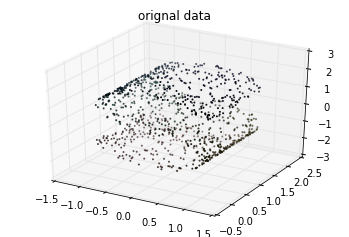

In [3]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X[:,0], X[:,1], X[:,2], c=color, s = 1)
plt.title('orignal data')
plt.show()

# The Geometry Class

In [4]:
from megaman.geometry import Geometry

Geometry is the main class that will Cache things like distance/adjacency, 
affinity, and laplacian. 

You instantiate the Geometry class with:

In [5]:
geom = Geometry()

At class instantiation you can also pass  parameters & methods for 
the three main components:

Adjacency: an NxN (sparse) pairwise matrix indicating neighborhood regions
Affinity an NxN (sparse) pairwise matrix insicated similarity between points 
Laplacian an NxN (sparse) pairwsie matrix containing geometric manifold information

These parameters can also be overwritten when using the individual calculation
functions so that you don't have to re-initialize every time you want to change
a parameter. 

If you already have fixed parameters then you can initialize with, for example:

In [6]:
radius = 1.0
adjacency_method = 'cyflann'
adjacency_kwds = {'radius':radius} # ignore distances above this radius
affinity_method = 'gaussian'
affinity_kwds = {'radius':radius} # A = exp(-||x - y||/radius^2) 
laplacian_method = 'geometric'
laplacian_kwds = {'scaling_epps':radius} # scaling ensures convergence to Laplace-Beltrami operator

geom = Geometry(adjacency_method=adjacency_method, adjacency_kwds=adjacency_kwds,
                affinity_method=affinity_method, affinity_kwds=affinity_kwds,
                laplacian_method=laplacian_method, laplacian_kwds=laplacian_kwds)

## Inputing your Data to Geometry

After you have instantiated the Geometry class there are the .set functions
which allow you to input your data to the Geometry object. As several methods
work potentially with different types of matrices and also to allow you to
assign your own Laplacian matrix without working through the API we have
the following set functions:

set_data_matrix(): input an (n_observation X n_dimensions) array of data points

set_adjacency_matrix(): input an (n_observation X n_observation) pairwise (sparse)
matrix indicating neighborhoods distances. This matrix should be sparse
with zero entries considered Infinite. The diagonal is considered explicitly
zero when calculating an affinity matrix. 

set_affinity_matrix(): input an (n_observation X n_observation) pairwise (sparse)
indicating similarity between points. High values indicate strong degree of 
similarity, the diagonal should take on the maximum value in its row.

In this example we're working with a data set of observed points and so we input with:

In [7]:
geom.set_data_matrix(X)

## Computing geometric matrices

Once you've input your data you may  be interested in computing the
various geometric matrices like the distance, affinity etc.

You can do this with the .compute functions.

If you passed a method parameter e.g. adjacency_method = 'cyflann'
then it will use this one. 

To update this use geom.adjacency_method = 'new_method_name'
you can pass new keywords to these functions.

In [8]:
adjacency_matrix = geom.compute_adjacency_matrix()

Note that by defualt this is pass-by-reference pass copy=True to get a copied version.

## Radius Selection

One important parameter to the adjacency function when using a
radius neighbors method is the radius parameter. There is no
default parameter for this as it should be chosen with care.

In general this is an iterative process and depends inherently
on the data itself. If the method does not produce the desired
result the radius can be adjusted in order to examine new
results.

In general you want to choose a small radius but one that is
large enough to result in a fully connected graph (or at least
a single large enough connected component). Connectedness
is most important with Spectral Embedding and Diffusion
Maps which are also the most scalable method. A too small
radius can break some embedding methods specifically if there
are neighbors with no or too few neighbors. 

You can check the connectedness of your affinity matrix
as follows:

In [9]:
from scipy.sparse.csgraph import connected_components

rad1 = 0.2
# compute an adjacency matrix with a radius
geom.adjacency_kwds = {'radius':rad1}
adjacency_matrix = geom.compute_adjacency_matrix()
# compute the corresponding affinity matrix
geom.affinity_kwds = {'radius':rad1}
affinity_matrix = geom.compute_affinity_matrix({'radius':rad1})
(number_connected_components, labels) = connected_components(affinity_matrix)
print(number_connected_components)

6


In [10]:
rad1 = 1.0
# compute an adjacency matrix with a radius
geom.adjacency_kwds = {'radius':rad1}
adjacency_matrix = geom.compute_adjacency_matrix()
# compute the corresponding affinity matrix
geom.affinity_kwds = {'radius':rad1}
affinity_matrix = geom.compute_affinity_matrix({'radius':rad1})
(number_connected_components, labels) = connected_components(affinity_matrix)
print(number_connected_components)

1


## Dictionary valued geometry

If you don't want to pre-compute a Geometry or you have previously
determined the parameters you can pass a dictionary or geometry
arguments to one of the embedding classes instead of a Geometry
object with the geom argument.

In [11]:
radius = 1.0
adjacency_method = 'cyflann'
adjacency_kwds = {'radius':radius}
affinity_method = 'gaussian'
affinity_kwds = {'radius':radius}
laplacian_method = 'geometric'
laplacian_kwds = {'scaling_epps':radius}

geom  = {'adjacency_method':adjacency_method, 'adjacency_kwds':adjacency_kwds,
         'affinity_method':affinity_method, 'affinity_kwds':affinity_kwds,
         'laplacian_method':laplacian_method, 'laplacian_kwds':laplacian_kwds}

# Embedding

Since we're going to use the same geometry object for each embedding we're
going to pass a geometry object instead of a dictionary.

In [12]:
geom = Geometry(adjacency_method=adjacency_method, adjacency_kwds=adjacency_kwds,
                affinity_method=affinity_method, affinity_kwds=affinity_kwds,
                laplacian_method=laplacian_method, laplacian_kwds=laplacian_kwds)
geom.set_data_matrix(X)

Now we will go through the API with the different embedding functions.

First import the classes:

In [13]:
from megaman.embedding import (Isomap, LocallyLinearEmbedding,
                               LTSA, SpectralEmbedding)

You have to select an output dimnension. Since the data lie on an S-curve
We pick dimension 2

In [14]:
n_components = 2

Once you have your geometry selected, each method works fairly simply.
Below demonstrates fitting each method:

In [15]:
spectral = SpectralEmbedding(n_components=n_components, eigen_solver='amg',geom=geom)
embed_spectral = spectral.fit_transform(X)

ltsa = LTSA(n_components=n_components,eigen_solver='arpack',geom=geom)
embed_ltsa = ltsa.fit_transform(X)

lle = LocallyLinearEmbedding(n_components=n_components, eigen_solver='arpack',geom=geom)
embed_lle = lle.fit_transform(X)

isomap = Isomap(n_components=n_components, eigen_solver='arpack',geom=geom)
embed_isomap = isomap.fit_transform(X)

## Visualization

We can examine the resulting embeddings in a 4x4 plot

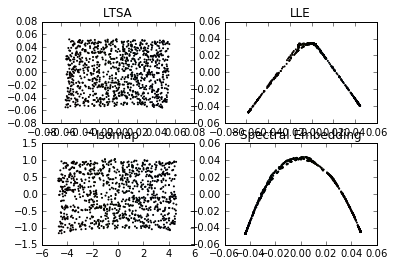

In [16]:
fig, axes = plt.subplots(nrows=2, ncols=2)
axes[0, 0].scatter(embed_ltsa[:, 0], embed_ltsa[:, 1], s=1, c=color)
axes[0, 0].set_title('LTSA')
axes[0, 1].scatter(embed_lle[:, 0], embed_lle[:, 1], s=1, c=color)
axes[0, 1].set_title('LLE')
axes[1, 0].scatter(embed_isomap[:, 0], embed_isomap[:, 1], s=1, c=color)
axes[1, 0].set_title('Isomap')
axes[1, 1].scatter(embed_spectral[:, 0], embed_spectral[:, 1], s=1, c=color)
axes[1, 1].set_title('Spectral Embedding')
plt.show()

# Riemannian Metric

The Riemannian Metric can be used to estimate the distortion in the embedding
and can also be used to calculat geometric qquantities isometrically with
respect to the original manifold.

In order to be able to compute a R. Metric you will need an embedding
and a Laplacian. 

If you plan to estimate the Riemannian Metric then when you
compute the Laplacian for best results you should use
laplacian_method = 'geometric' and set the keyword
parameter 'scaling_epps' to the 'radius' that was used
in the affinity method.

First import the class:

In [17]:
from megaman.geometry.rmetric import RiemannMetric

We can then estimate the R metric on each embedding with:

In [18]:
rmetric_spectral = RiemannMetric(embed_spectral, geom.laplacian_matrix)
H_spectral = rmetric_spectral.get_dual_rmetric()

rmetric_ltsa = RiemannMetric(embed_ltsa, geom.laplacian_matrix)
H_ltsa = rmetric_ltsa.get_dual_rmetric()

rmetric_lle = RiemannMetric(embed_lle, geom.laplacian_matrix)
H_lle = rmetric_lle.get_dual_rmetric()

rmetric_isomap = RiemannMetric(embed_isomap, geom.laplacian_matrix)
H_isomap = rmetric_isomap.get_dual_rmetric()

We can use the cover_plotter module included in megaman to
plot a subset of the points as ellipses representing the
distortion.

Here's an example of using it with the isomap embedding.

Note that we use equal aspect ratio otherwise it is hard
to determine what the actual distortion is.

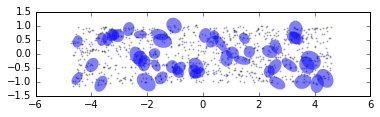

In [19]:
import numpy as np
from covar_plotter import plot_cov_ellipse

# <rmetric plot code>
n_plot = 50
sample_points = np.random.choice(range(N), n_plot, replace = False)
f, ax = plt.subplots()
ax.scatter(embed_isomap[:, 0], embed_isomap[:, 1], s = 1, alpha = 0.25)
ax.set_aspect('equal') # if an ellipse is a circle no distortion occured. 
for i in range(n_plot):
    ii = sample_points[i]
    cov = H_isomap[ii, :, :]
    plot_cov_ellipse(cov*0.1, embed_isomap[ii, :] ,ax=ax, edgecolor='none', alpha = 0.5)
plt.show()

# Best parameters for large data sets

## Adjacency Matrix -- using FLANN

Although megaman works equally well with small data sets when using
a data set of significant size (N > 10,000 or so and D > 100 or so)
there are a few things that should be considered.

For compute_adjacency_matrix it is best to use 'method' = 'cyflann'.

The 'cyflann' itself has several parameters that can be adjusted.

the 'cyflann' method defaults to 'kmeans' which has additional
parameters that can be accessed with:

In [20]:
import time
N = 100000
X, color = datasets.samples_generator.make_s_curve(N, random_state=0)
radius = 1.5
adjacency_method = 'cyflann'
cyflann_kwds = {'index_type':'kmeans', 'branching':64, 'iterations':20, 'cb_index':0.4}
adjacency_kwds = {'radius':radius, 'cyflann_kwds':cyflann_kwds}
affinity_method = 'gaussian'
affinity_kwds = {'radius':radius}
laplacian_method = 'geometric'
laplacian_kwds = {'scaling_epps':radius}

geom = Geometry(adjacency_method=adjacency_method, adjacency_kwds=adjacency_kwds,
                affinity_method=affinity_method, affinity_kwds=affinity_kwds,
                laplacian_method=laplacian_method, laplacian_kwds=laplacian_kwds)
geom.set_data_matrix(X)
t0 = time.time()
adjacency_matrix = geom.compute_adjacency_matrix()
t1 = time.time() - t0
print(t1)

3.06213188171


cyflann also has the option to use 'kdtrees' which has parameters

In [21]:
N = 100000
X, color = datasets.samples_generator.make_s_curve(N, random_state=0)
radius = 1.5
adjacency_method = 'cyflann'
cyflann_kwds = {'index_type':'kdtrees', 'num_trees':10}
adjacency_kwds = {'radius':radius, 'cyflann_kwds':cyflann_kwds}
affinity_method = 'gaussian'
affinity_kwds = {'radius':radius}
laplacian_method = 'geometric'
laplacian_kwds = {'scaling_epps':radius}

geom = Geometry(adjacency_method=adjacency_method, adjacency_kwds=adjacency_kwds,
                affinity_method=affinity_method, affinity_kwds=affinity_kwds,
                laplacian_method=laplacian_method, laplacian_kwds=laplacian_kwds)
geom.set_data_matrix(X)
t0 = time.time()
adjacency_matrix = geom.compute_adjacency_matrix()
t1 = time.time() - t0
print(t1)

3.43261909485


Choosing between these two options and their parameters ultimately
depends on the data. If the 'kmeans' method does not produce
satisfactory results then one should try the 'kdtrees' and also
adjust their parameters. 

## Embeddings

The embeddings methods do not all scale equally. In particular
they are from best scaling to worst scaling:

Spectral Embedding & Diffusion Maps, Local Tangent Space Alignment,
Locally Linear Embedding, Isomap

Therefore for the largest data sets it is best to use either
Spectral Embedding or Diffusion Maps. 

Furthermore when selecting the eigen_solver for best results
use 'amg' which uses pre-conditioning. Method 'lobpcg' 
will work on large data sets but depends heavily on the 
initial estimation without the assistance of 'amg'.